# I've decided to redistribute 0.0252 of the probability mass for event zero across the other event spaces, starting with the events with the smallest mass first. That effect is as such:



| TWF | HDF | PWF | OSF | RNF | joint_PWF_OSF | joint_TWF_RNF | joint_HDF_PWF | joint_HDF_OSF | joint_TWF_OSF | joint_TWF_PWF_OSF |    count | P(outcome) |
| --: | --: | --: | --: | --: | ------------: | ------------: | ------------: | ------------: | ------------: | ----------------: | -------: | ---------: |
|   0 |   0 |   0 |   0 |   0 |             0 |             0 |             0 |             0 |             0 |                 0 | **9400** | **0.9400** |
|   0 |   0 |   1 |   0 |   0 |             0 |             0 |             0 |             0 |             0 |                 0 |       80 |     0.0080 |
|   0 |   0 |   0 |   0 |   0 |             1 |             0 |             0 |             0 |             0 |                 0 |       42 |     0.0042 |
|   1 |   0 |   0 |   0 |   0 |             0 |             0 |             0 |             0 |             0 |                 0 |       42 |     0.0042 |
|   0 |   0 |   0 |   1 |   0 |             0 |             0 |             0 |             0 |             0 |                 0 |       78 |     0.0078 |
|   0 |   0 |   0 |   0 |   1 |             0 |             0 |             0 |             0 |             0 |                 0 |       42 |     0.0042 |
|   0 |   1 |   0 |   0 |   0 |             0 |             0 |             0 |             0 |             0 |                 0 |      106 |     0.0106 |
|   0 |   0 |   0 |   0 |   0 |             0 |             1 |             0 |             0 |             0 |                 0 |       42 |     0.0042 |
|   0 |   0 |   0 |   0 |   0 |             0 |             0 |             1 |             0 |             0 |                 0 |       42 |     0.0042 |
|   0 |   0 |   0 |   0 |   0 |             0 |             0 |             0 |             1 |             0 |                 0 |       42 |     0.0042 |
|   0 |   0 |   0 |   0 |   0 |             0 |             0 |             0 |             0 |             1 |                 0 |       42 |     0.0042 |
|   0 |   0 |   0 |   0 |   0 |             0 |             0 |             0 |             0 |             0 |                 1 |       42 |     0.0042 |


In [123]:
from iterstrat.ml_stratifiers import (
    MultilabelStratifiedShuffleSplit,
    MultilabelStratifiedKFold
)
import numpy as np
import pandas as pd
import random
import os

from pyprojroot import here
import seaborn as sns
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
from matplotlib import pyplot as plt
from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.metrics import AUC, Recall, Precision, F1Score


import keras_tuner as kt
from keras_tuner import HyperParameters


from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, auc as sk_auc
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import scipy

import wandb
from wandb.integration.keras import WandbCallback
from wandb.integration.keras import WandbModelCheckpoint


In [124]:
multi_label_data = pd.read_csv(here('data/processed/joint_target_vectors_df.csv'))

In [125]:
multi_label_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   quality_variation        10000 non-null  int64  
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  float64
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  float64
 6   TWF                      10000 non-null  int64  
 7   HDF                      10000 non-null  int64  
 8   PWF                      10000 non-null  int64  
 9   OSF                      10000 non-null  int64  
 10  RNF                      10000 non-null  int64  
 11  joint_PWF_OSF            10000 non-null  int64  
 12  joint_TWF_RNF            10000 non-null  int64  
 13  joint_HDF_PWF            10000 non-null  int64  
 14  joint_HDF_OSF          

In [126]:
df_x_y = multi_label_data.copy()


X = df_x_y.drop(columns=[
    'TWF','HDF','PWF','OSF',
    'RNF','joint_PWF_OSF',
    'joint_TWF_RNF','joint_HDF_PWF',
    'joint_HDF_OSF','joint_TWF_OSF',
    'joint_TWF_PWF_OSF'
])

Y = df_x_y.iloc[:, 6:].copy()


target_cols = list(Y.columns)

In [127]:
under_strategy = {
    "no_fail": 833
}

In [128]:
def random_underSampler(X, Y, under_strategy, random_state=7):
    """
    Undersample using a dict-based strategy on a binary target:
        0 = no_fail  (all targets == 0)
        1 = any_fail (at least one target == 1)

    Parameters
    ----------
    X : DataFrame
    Y : DataFrame (multi-label, mutually exclusive: 0 or 1 per col; 0 or 1 active)
    under_strategy : dict
        Keys are the binary class labels (0 and/or 1),
        values are desired sample counts for those classes.
        Typically: {0: desired_no_fail_count}
        (class 1 entries are optional; if omitted, failures are left untouched)
    """
    # binary view
    any_fail = (Y.sum(axis=1) > 0)
    y_bin = any_fail.astype(int)  # 0 = no_fail, 1 = any_fail

    # original distribution
    unique, counts = np.unique(y_bin, return_counts=True)
    print("Original binary class counts (0=no_fail, 1=any_fail):")
    for u, c in zip(unique, counts):
        print(f"  {u}: {c}")

    # clamp requested counts if needed (especially for class 0)
    strat = dict(under_strategy)  # copy so we don't mutate caller's dict
    if 0 in strat:
        n0 = int((y_bin == 0).sum())
        if strat[0] > n0:
            print(f"[WARN] under_strategy[0]={strat[0]} > available_no_fail={n0}. Clamping to {n0}.")
            strat[0] = n0

    rus = RandomUnderSampler(
        sampling_strategy=strat,
        random_state=random_state
    )

    # fit_resample on numpy, then index back into X,Y using rus.sample_indices_
    X_np = X.values
    rus.fit_resample(X_np, y_bin)
    idx = rus.sample_indices_

    X_res = X.iloc[idx].reset_index(drop=True)
    Y_res = Y.iloc[idx].reset_index(drop=True)

    # check new distribution
    y_bin_res = (Y_res.sum(axis=1) > 0).astype(int)
    unique_res, counts_res = np.unique(y_bin_res, return_counts=True)
    print("Resampled binary class counts (0=no_fail, 1=any_fail):")
    for u, c in zip(unique_res, counts_res):
        print(f"  {u}: {c}")

    return X_res, Y_res

In [129]:
def probability_mass_shifter(X, Y, over_strategy, random_state=7):
    """
    Oversample minority *failure* classes using a dict strategy
    on the mutually-exclusive event labels.

    Steps:
      - Ensure each row is either all zeros (no_fail) or exactly one positive.
      - Map each row to an event label:
           'no_fail' or one of target column names.
      - Apply RandomOverSampler with `over_strategy`:
           { 'TWF': 833, 'HDF': 833, ... }
        Keys: event labels to oversample
        Values: desired counts AFTER oversampling.
        Labels not in the dict are left unchanged.
      - Rebuild multi-label Y from the oversampled event labels.

    NOTE:
      This function does *not* undersample. Call random_underSampler
      first if you want both.
    """
    rng = np.random.RandomState(random_state)

    # validate exclusivity
    Y_vals = Y.values
    row_sums = Y_vals.sum(axis=1)
    if not np.all((row_sums == 0) | (row_sums == 1)):
        raise ValueError(
            "probability_mass_shifter assumes each row is no_fail or exactly one active label."
        )

    cols = np.array(Y.columns)

    # map to event labels
    argmax = Y_vals.argmax(axis=1)
    y_events = np.where(row_sums == 0, 'no_fail', cols[argmax])

    # current counts
    current_counts = pd.Series(y_events).value_counts().sort_index()
    print("\nEvent counts BEFORE oversample:")
    print(current_counts)

    # filter strategy to valid, truly oversampled targets
    sampling_strategy = {}
    for lbl, desired in over_strategy.items():
        if lbl not in current_counts.index:
            print(f"[WARN] {lbl} not present, skipping in over_strategy.")
            continue
        current = int(current_counts[lbl])
        if desired <= current:
            print(f"[INFO] {lbl}: desired={desired} <= current={current}, no oversample.")
            continue
        sampling_strategy[lbl] = desired

    if not sampling_strategy:
        print("\n[INFO] No valid oversampling requested. Returning original X,Y.")
        return X.reset_index(drop=True), Y.reset_index(drop=True)

    ros = RandomOverSampler(
        sampling_strategy=sampling_strategy,
        random_state=random_state
    )

    # Oversample on events; X can be DataFrame directly
    X_res, y_events_res = ros.fit_resample(X, y_events)

    # Rebuild multi-label Y from oversampled events
    n = len(y_events_res)
    Y_res = pd.DataFrame(
        0,
        index=np.arange(n),
        columns=Y.columns
    )

    col_index = {c: j for j, c in enumerate(Y.columns)}

    for i, lab in enumerate(y_events_res):
        if lab == 'no_fail':
            continue
        if lab not in col_index:
            # should not happen if over_strategy uses valid labels
            continue
        j = col_index[lab]
        Y_res.iat[i, j] = 1

    # sanity summary
    final_counts = Y_res.sum()
    no_fail_final = (Y_res.sum(axis=1) == 0).sum()
    print("\nEvent counts AFTER oversample (reconstructed from Y_res):")
    print("  no_fail:", no_fail_final)
    for c in Y.columns:
        print(f"  {c}: {int(final_counts[c])}")
    print("  total rows:", len(Y_res))

    return X_res.reset_index(drop=True), Y_res.reset_index(drop=True)

In [130]:
def multilabel_train_val_test_splits(
    X_df, Y_df, *,
    test_size=0.20,
    n_splits=5,
    random_state=42
):
    """
    Assumes X_df, Y_df are ALREADY rebalanced via:
        X_under, Y_under = random_underSampler(...)
        X_bal,   Y_bal   = probability_mass_shifter(...)

    This function ONLY:
      1) Uses MultiLabelStratifiedShuffleSplit -> TRAIN+VAL vs TEST.
      2) Uses MultiLabelStratifiedKFold on TRAIN+VAL to create K stratified folds.

    Returns
    -------
    folds : list of dicts
        Each:
        {
          "fold": fold_id,
          "X_train": X_tr,
          "Y_train": Y_tr,
          "X_val":   X_va,
          "Y_val":   Y_va,
        }

    (X_test, Y_test) : tuple of DataFrames
        Held-out multi-label stratified test set.
    """
    # make copies, enforce int labels
    X = X_df.reset_index(drop=True)
    Y = Y_df.reset_index(drop=True).astype(int)

    # ---------- 1. Outer ML-stratified train+val vs test ----------
    msss = MultilabelStratifiedShuffleSplit(
        n_splits=1,
        test_size=test_size,
        random_state=random_state
    )

    # msss.split expects numpy arrays
    (trainval_idx, test_idx), = msss.split(X.values, Y.values)

    X_trainval = X.iloc[trainval_idx].reset_index(drop=True)
    Y_trainval = Y.iloc[trainval_idx].reset_index(drop=True)

    X_test = X.iloc[test_idx].reset_index(drop=True)
    Y_test = Y.iloc[test_idx].reset_index(drop=True)

    # ---------- 2. Inner ML-stratified K-fold on train+val ----------
    mskf = MultilabelStratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    folds = []
    for fold_id, (tr_idx, val_idx) in enumerate(
        mskf.split(X_trainval.values, Y_trainval.values), start=1
    ):
        X_tr = X_trainval.iloc[tr_idx].reset_index(drop=True)
        Y_tr = Y_trainval.iloc[tr_idx].reset_index(drop=True)

        X_va = X_trainval.iloc[val_idx].reset_index(drop=True)
        Y_va = Y_trainval.iloc[val_idx].reset_index(drop=True)

        folds.append({
            "fold": fold_id,
            "X_train": X_tr,
            "Y_train": Y_tr,
            "X_val":   X_va,
            "Y_val":   Y_va,
        })

        # sanity print; safe for your notebook flow
        print(f"Fold {fold_id}: train={len(X_tr)}, val={len(X_va)}")

    return folds, (X_test, Y_test)


In [131]:
# 1) define strategies
under_strategy = {0: 4500}

over_strategy = {
    'TWF': 1200,
    'HDF': 1200,
    'PWF': 1200,
    'OSF': 1200,
    'RNF': 1200,
    'joint_PWF_OSF': 1200,
    'joint_TWF_RNF': 1200,
    'joint_HDF_PWF': 1200,
    'joint_HDF_OSF': 2000,
    'joint_TWF_OSF': 2000,
    'joint_TWF_PWF_OSF': 2000,
}


In [132]:
# undersample majority
X_under, Y_under = random_underSampler(X, Y, under_strategy=under_strategy, random_state=42)

# oversample minorities
X_bal, Y_bal = probability_mass_shifter(X_under, Y_under, over_strategy=over_strategy, random_state=42)


Original binary class counts (0=no_fail, 1=any_fail):
  0: 9652
  1: 348
Resampled binary class counts (0=no_fail, 1=any_fail):
  0: 4500
  1: 348

Event counts BEFORE oversample:
HDF                   106
OSF                    78
PWF                    80
RNF                    18
TWF                    42
joint_HDF_OSF           6
joint_HDF_PWF           3
joint_PWF_OSF          11
joint_TWF_OSF           2
joint_TWF_PWF_OSF       1
joint_TWF_RNF           1
no_fail              4500
Name: count, dtype: int64

Event counts AFTER oversample (reconstructed from Y_res):
  no_fail: 4500
  TWF: 1200
  HDF: 1200
  PWF: 1200
  OSF: 1200
  RNF: 1200
  joint_PWF_OSF: 1200
  joint_TWF_RNF: 1200
  joint_HDF_PWF: 1200
  joint_HDF_OSF: 2000
  joint_TWF_OSF: 2000
  joint_TWF_PWF_OSF: 2000
  total rows: 20100


In [133]:
print("\nSHAPES:")
print("Original:        ", X.shape, Y.shape)
print("After under:     ", X_under.shape, Y_under.shape)
print("After over/bal:  ", X_bal.shape, Y_bal.shape)



SHAPES:
Original:         (10000, 6) (10000, 11)
After under:      (4848, 6) (4848, 11)
After over/bal:   (20100, 6) (20100, 11)


In [134]:
folds, (X_test, Y_test) = multilabel_train_val_test_splits(
    X_bal, Y_bal,
    test_size=0.10,
    n_splits=5,
    random_state=42
)
print("Y_bal total rows:", len(Y_bal))
print("Y_bal per-label counts:")
print(Y_bal.sum(axis=0))

print(f"\nTest shape: {X_test.shape}, {Y_test.shape}")
for f in folds:
    print(f"Fold {f['fold']}: train={len(f['X_train'])}, val={len(f['X_val'])}")

Fold 1: train=14472, val=3618
Fold 2: train=14472, val=3618
Fold 3: train=14472, val=3618
Fold 4: train=14472, val=3618
Fold 5: train=14472, val=3618
Y_bal total rows: 20100
Y_bal per-label counts:
TWF                  1200
HDF                  1200
PWF                  1200
OSF                  1200
RNF                  1200
joint_PWF_OSF        1200
joint_TWF_RNF        1200
joint_HDF_PWF        1200
joint_HDF_OSF        2000
joint_TWF_OSF        2000
joint_TWF_PWF_OSF    2000
dtype: int64

Test shape: (2010, 6), (2010, 11)
Fold 1: train=14472, val=3618
Fold 2: train=14472, val=3618
Fold 3: train=14472, val=3618
Fold 4: train=14472, val=3618
Fold 5: train=14472, val=3618


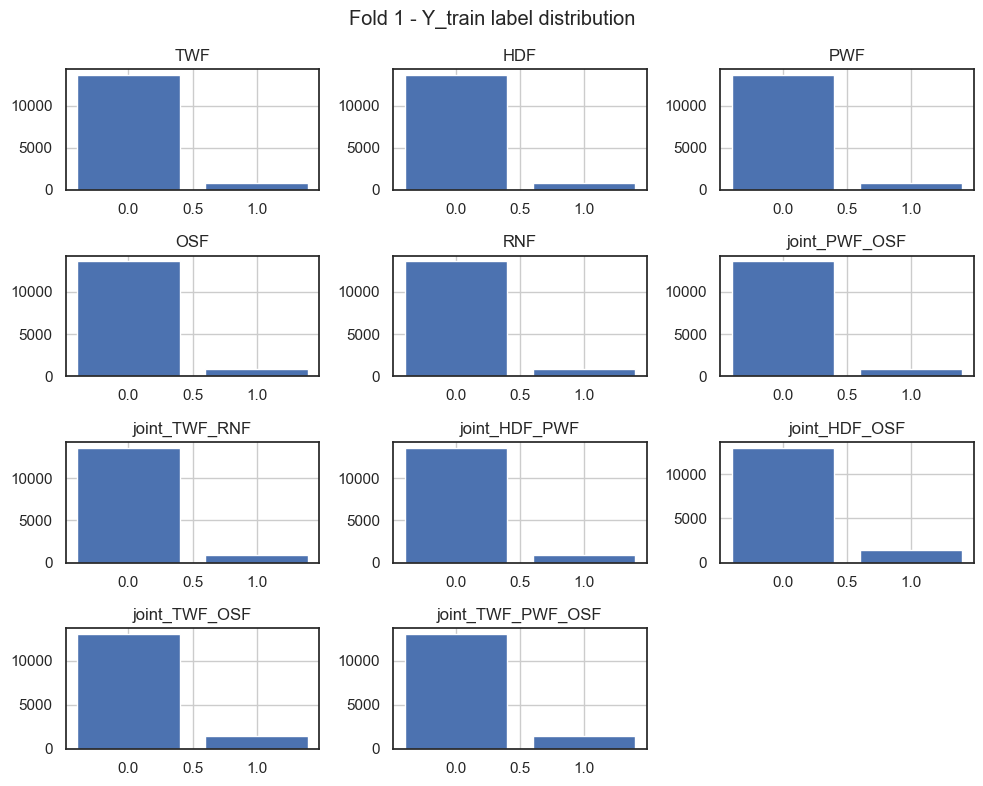

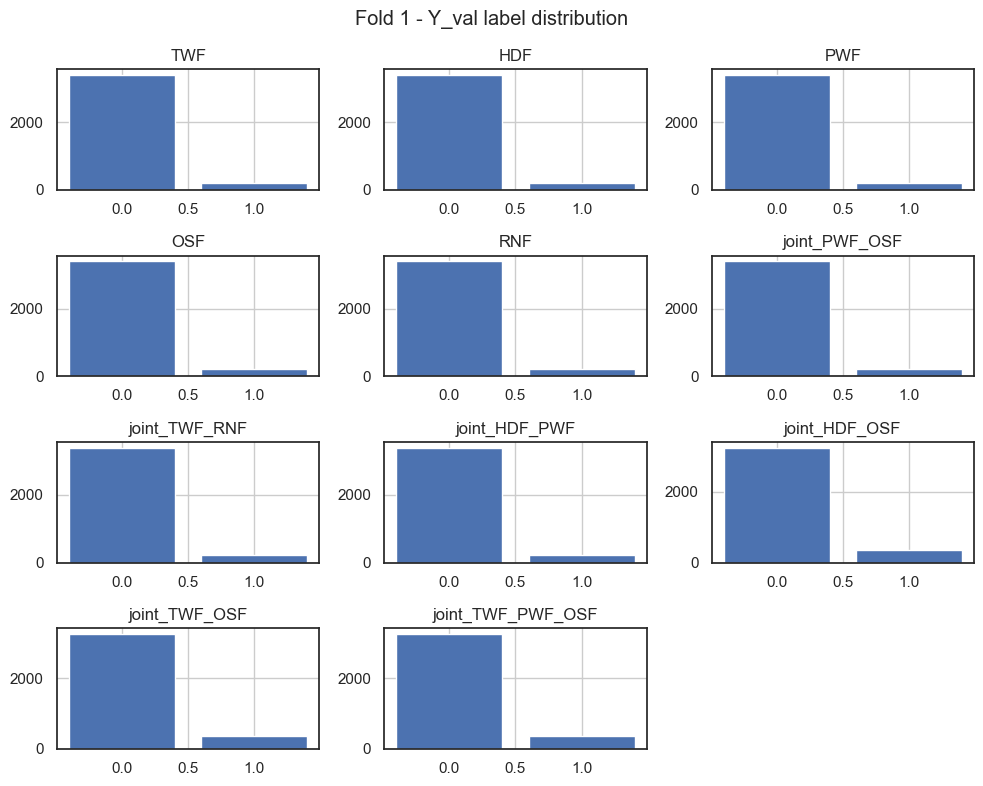

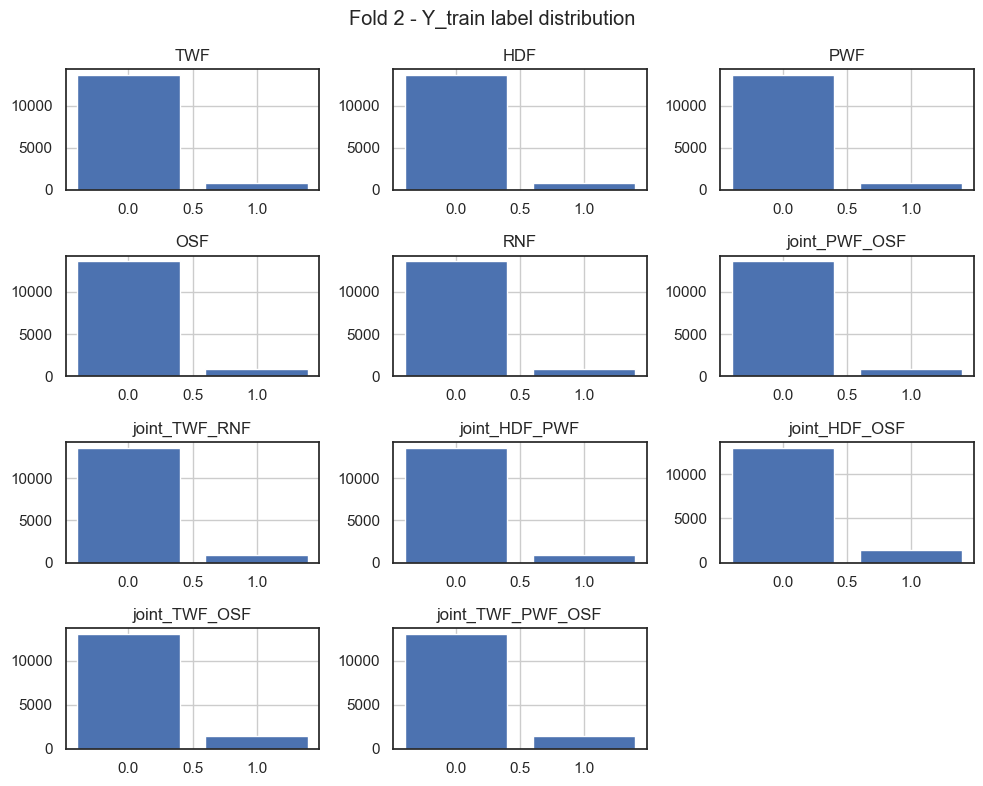

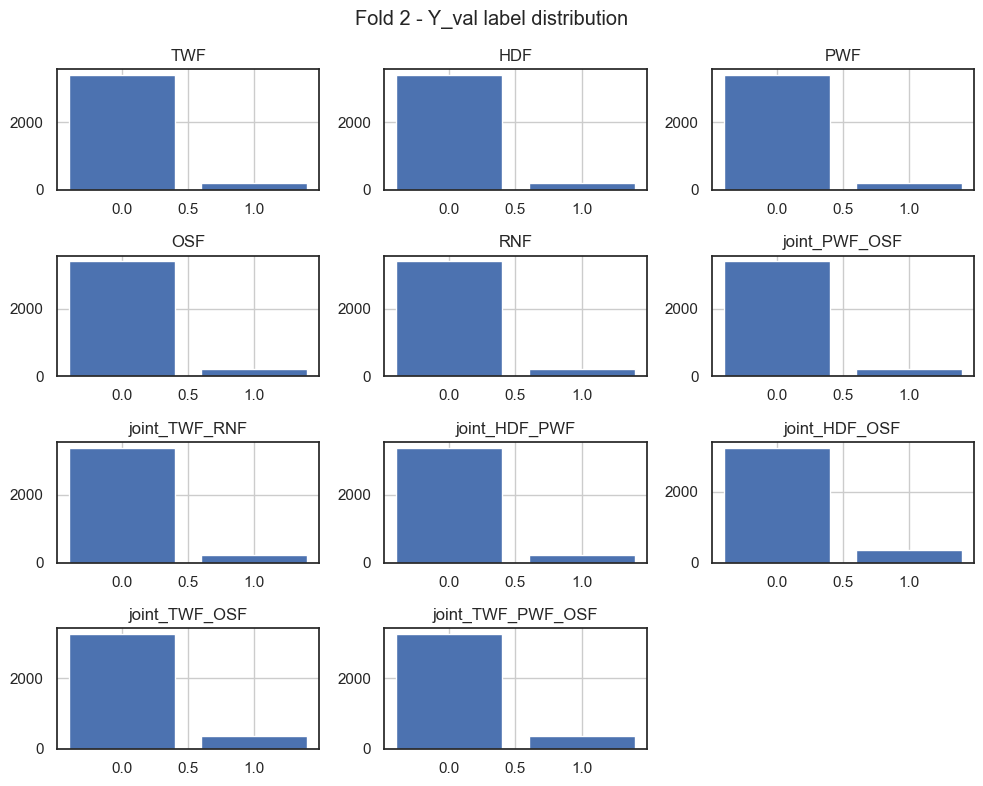

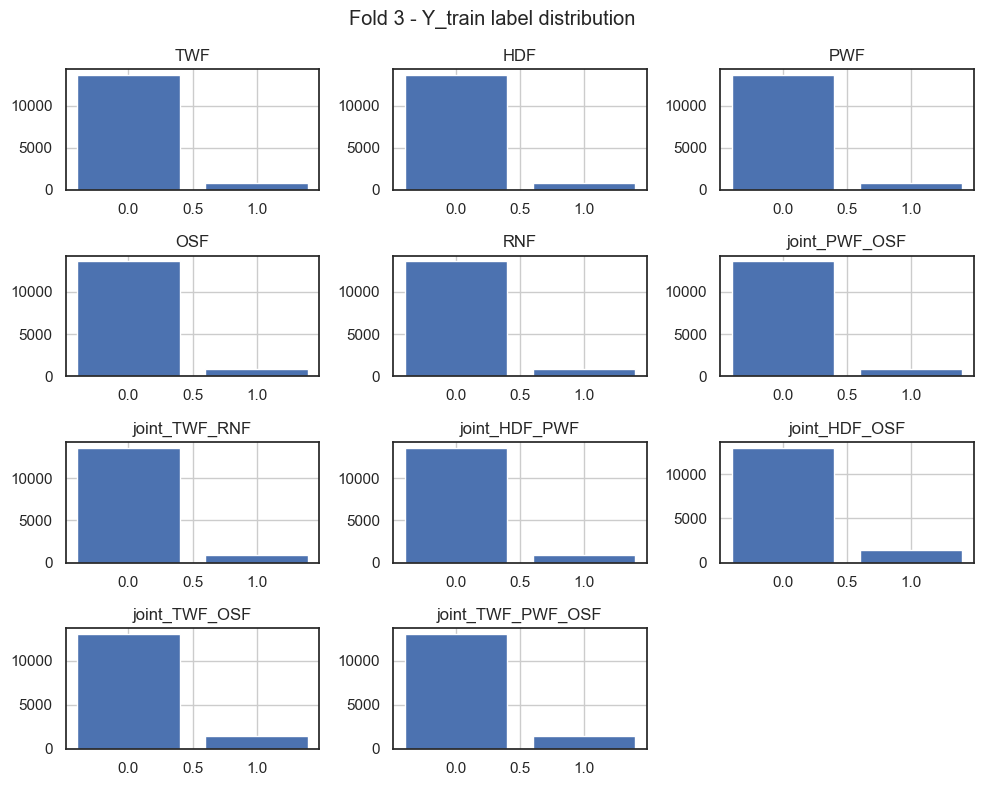

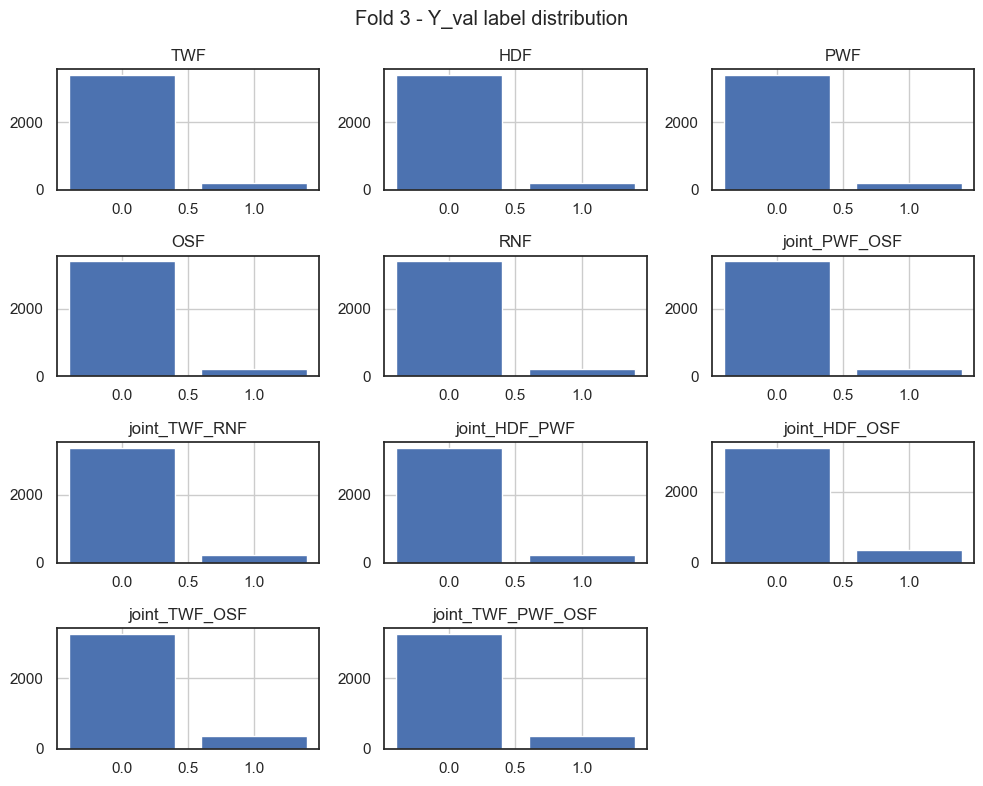

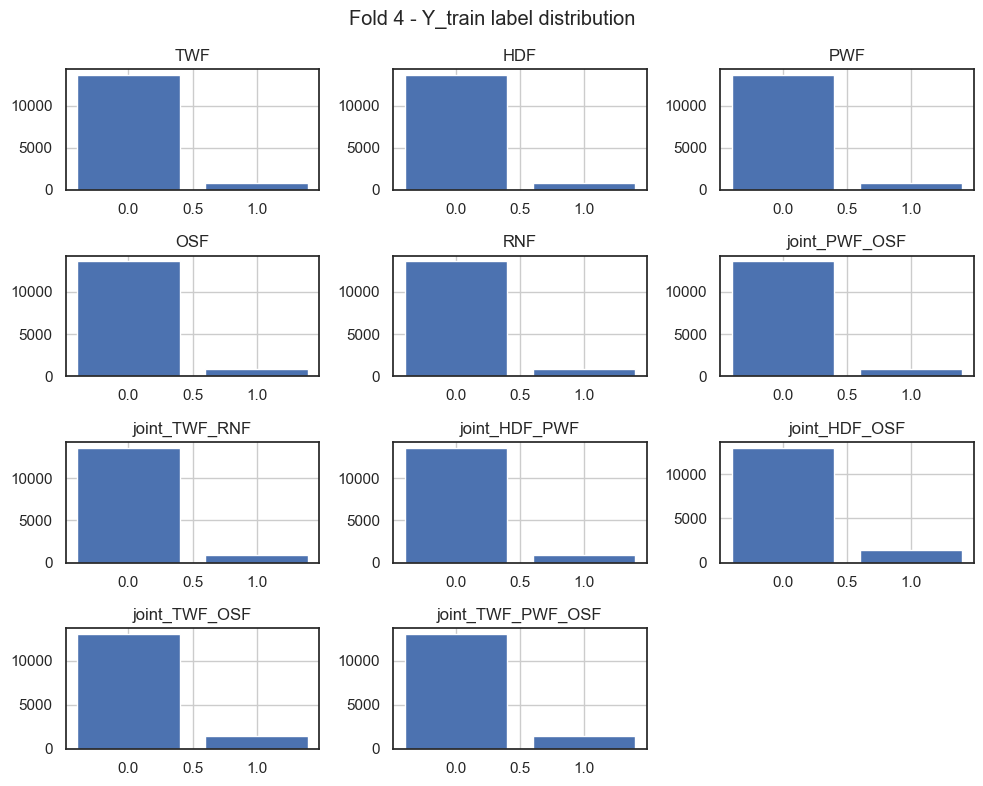

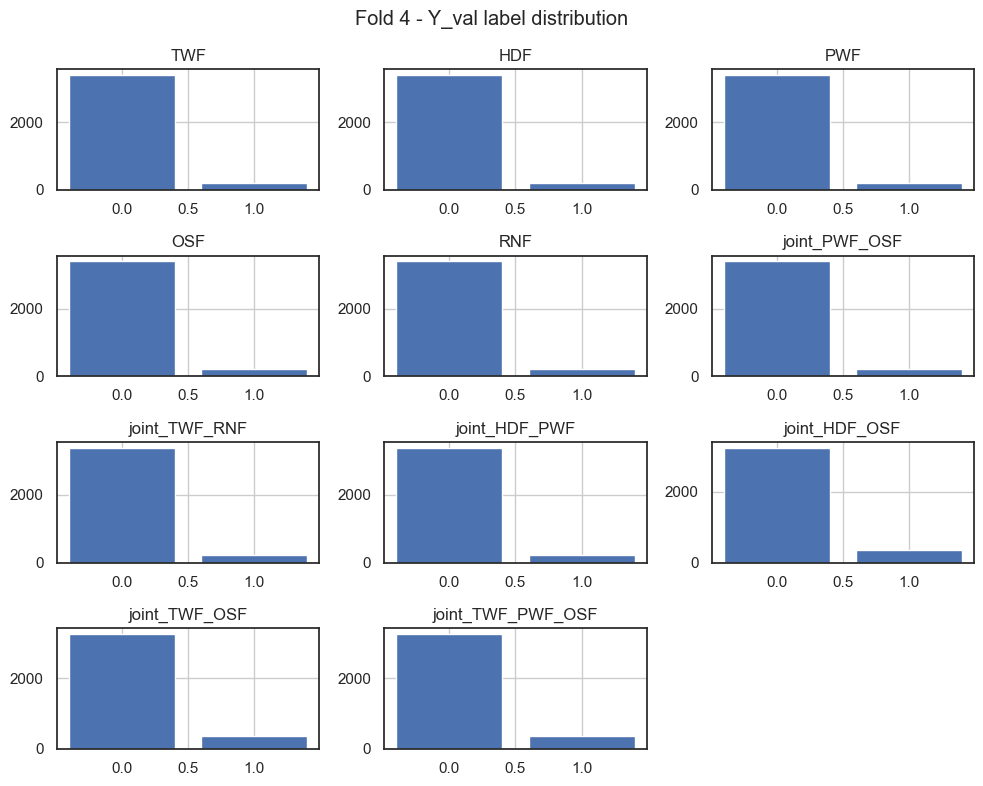

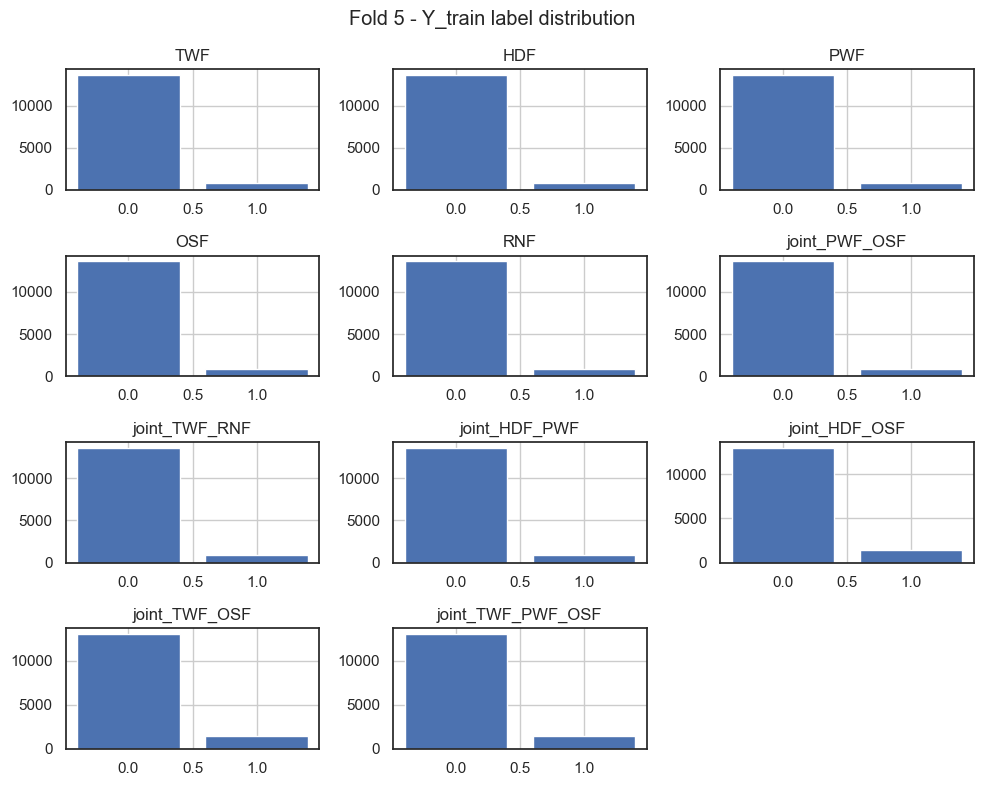

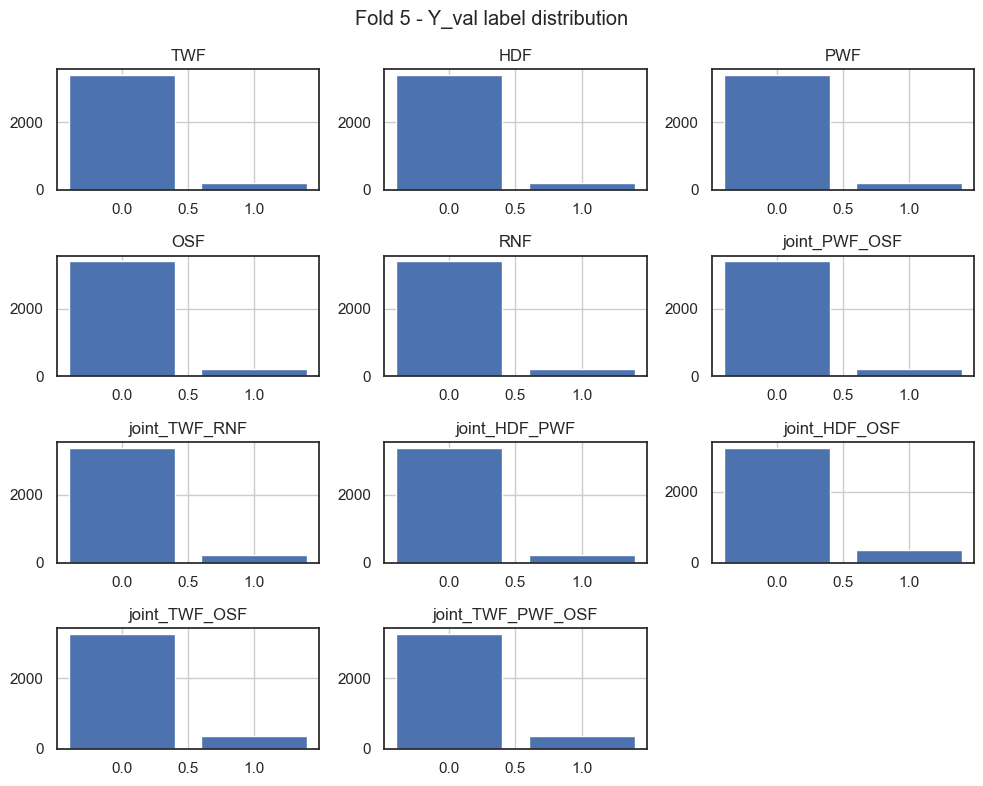

In [135]:
# Histograms for each fold: Y_train and Y_val
for f in folds:
    k = f['fold']

    # Training labels
    f['Y_train'][target_cols].hist(
        bins=[-0.5, 0.5, 1.5],
        layout=(4, 3),
        figsize=(10, 8),
        rwidth=0.8
    )
    plt.suptitle(f"Fold {k} - Y_train label distribution")
    plt.tight_layout()
    plt.show()

    # Validation labels
    f['Y_val'][target_cols].hist(
        bins=[-0.5, 0.5, 1.5],
        layout=(4, 3),
        figsize=(10, 8),
        rwidth=0.8
    )
    plt.suptitle(f"Fold {k} - Y_val label distribution")
    plt.tight_layout()
    plt.show()


In [136]:
def compute_LD(Y_full, subsets):
    """
    Label Distribution: average |p_subset(label) - p_full(label)|
    across labels and subsets.
    """
    Y_full = np.asarray(Y_full)
    N, q = Y_full.shape
    p_full = Y_full.sum(axis=0) / N

    diffs = []
    for i in range(q):
        label_diffs = []
        for Y_sub in subsets:
            Ys = np.asarray(Y_sub)
            Nj = Ys.shape[0]
            if Nj == 0:
                continue
            p_sub = Ys[:, i].sum() / Nj
            label_diffs.append(abs(p_sub - p_full[i]))
        diffs.append(np.mean(label_diffs))
    return float(np.mean(diffs))

def compute_ED(N_full, subset_sizes):
    """
    Example Distribution: mean | |Sj| - cj |, where cj = N_full / k.
    """
    k = len(subset_sizes)
    cj = N_full / k
    return float(np.mean([abs(sz - cj) for sz in subset_sizes]))

def compute_FZ_FLZ(subsets):
    """
    FZ: #folds with ≥1 label having zero positives.
    FLZ: total # of (fold, label) pairs with zero positives.
    """
    FZ = 0
    FLZ = 0
    for Y_sub in subsets:
        zero_mask = (Y_sub.sum(axis=0) == 0)
        if zero_mask.any():
            FZ += 1
            FLZ += int(zero_mask.sum())
    return FZ, FLZ

# Build lists of subset label matrices
train_subsets = [f['Y_train'][target_cols] for f in folds]
val_subsets   = [f['Y_val'][target_cols] for f in folds]

N_full = len(Y_bal)

print("\n=== TRAIN folds LD/ED/FZ/FLZ (vs balanced data) ===")
LD_train = compute_LD(Y_bal[target_cols], train_subsets)
ED_train = compute_ED(N_full, [len(y) for y in train_subsets])
FZ_train, FLZ_train = compute_FZ_FLZ(train_subsets)
print(f"LD_train : {LD_train:.6f}")
print(f"ED_train : {ED_train:.2f}")
print(f"FZ_train : {FZ_train}")
print(f"FLZ_train: {FLZ_train}")

print("\n=== VAL folds LD/ED/FZ/FLZ (vs balanced data) ===")
LD_val = compute_LD(Y_bal[target_cols], val_subsets)
ED_val = compute_ED(N_full, [len(y) for y in val_subsets])
FZ_val, FLZ_val = compute_FZ_FLZ(val_subsets)
print(f"LD_val : {LD_val:.6f}")
print(f"ED_val : {ED_val:.2f}")
print(f"FZ_val : {FZ_val}")
print(f"FLZ_val: {FLZ_val}")



=== TRAIN folds LD/ED/FZ/FLZ (vs balanced data) ===
LD_train : 0.000000
ED_train : 10452.00
FZ_train : 0
FLZ_train: 0

=== VAL folds LD/ED/FZ/FLZ (vs balanced data) ===
LD_val : 0.000000
ED_val : 402.00
FZ_val : 0
FLZ_val: 0


In [137]:
processed_dir = here("data/processed")
# --- Save test split ---
X_test.to_csv(here("processed", "X_test.csv"), index=False)
Y_test.to_csv(here("processed", "Y_test.csv"), index=False)

# --- Save CV folds (matches your directory naming) ---
for fold in folds:
    k = fold["fold"]  # assumes 1..5
    fold["X_train"].to_csv(here("processed", f"fold_{k}_X_train.csv"), index=False)
    fold["Y_train"].to_csv(here("processed", f"fold_{k}_Y_train.csv"), index=False)
    fold["X_val"].to_csv(here("processed", f"fold_{k}_X_val.csv"), index=False)
    fold["Y_val"].to_csv(here("processed", f"fold_{k}_Y_val.csv"), index=False)

# --- Log all CSVs as a single artifact in Weights & Biases ---
run = wandb.init(
    project="mlds_multilabel_cv",      # <= set your W&B project name
    job_type="export_splits"
)

artifact = wandb.Artifact(
    name="multilabel_stratified_splits",
    type="dataset",
    description="5-fold multilabel stratified CV splits + test set"
)

for fname in sorted(os.listdir(processed_dir)):
    if fname.endswith(".csv"):
        artifact.add_file(here("processed", fname), name=fname)

run.log_artifact(artifact)
run.finish()